In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
class sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        eps = keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_logvar) * eps

In [11]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_logvar = layers.Dense(latent_dim, name='z_log_var')(x)
z = sampling()([z_mean, z_logvar])
encoder = keras.Model(encoder_inputs, [z_mean, z_logvar, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['input_5[0][0]']                
                                                                                                  
 dense_16 (Dense)               (None, 128)          100480      ['flatten_2[0][0]']              
                                                                                                  
 dense_17 (Dense)               (None, 512)          66048       ['dense_16[0][0]']               
                                                                                            

In [12]:
latent_inputs = keras.Input(shape=(latent_dim, ))
x = layers.Dense(128, activation='relu')(latent_inputs)
#x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(28 * 28, activation='relu')(x)
decoder_output = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_20 (Dense)            (None, 128)               384       
                                                                 
 dense_21 (Dense)            (None, 512)               66048     
                                                                 
 dense_22 (Dense)            (None, 1024)              525312    
                                                                 
 dense_23 (Dense)            (None, 784)               803600    
                                                                 
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 1,395,344
Trainable params: 1,395,344
Non-tra

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [14]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 2s 2ms/step - loss: 387.1615 - reconstruction_loss: 347.2955 - kl_loss: 3.8152
Epoch 2/30
547/547 [==============================] - 1s 2ms/step - loss: 295.2979 - reconstruction_loss: 285.2674 - kl_loss: 4.5076
Epoch 3/30
547/547 [==============================] - 1s 2ms/step - loss: 287.9716 - reconstruction_loss: 277.7556 - kl_loss: 4.8054
Epoch 4/30
547/547 [==============================] - 1s 2ms/step - loss: 269.5867 - reconstruction_loss: 263.3462 - kl_loss: 4.8780
Epoch 5/30
547/547 [==============================] - 1s 2ms/step - loss: 268.6886 - reconstruction_loss: 259.4189 - kl_loss: 5.0793
Epoch 6/30
547/547 [==============================] - 1s 2ms/step - loss: 260.1724 - reconstruction_loss: 252.4218 - kl_loss: 5.1101
Epoch 7/30
547/547 [==============================] - 1s 2ms/step - loss: 259.4636 - reconstruction_loss: 254.0599 - kl_loss: 5.0451
Epoch 8/30
547/547 [==============================] - 1s 2ms/step - l

1/1 [==============================] - 0s 10ms/step


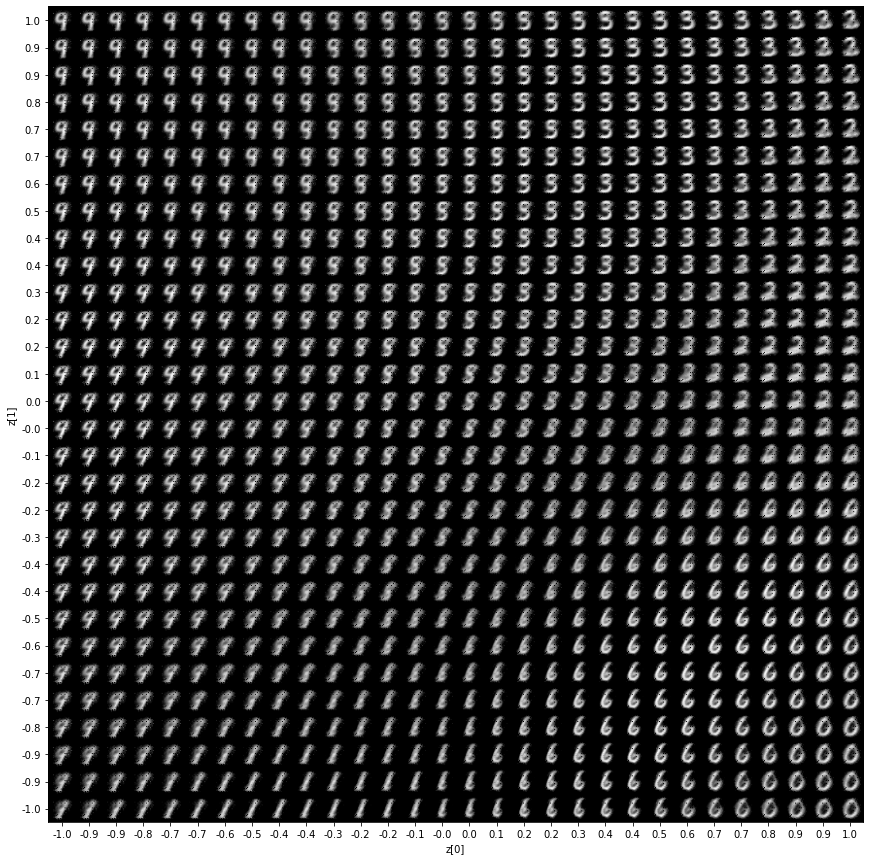

In [15]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

1875/1875 [==============================] - 1s 581us/step


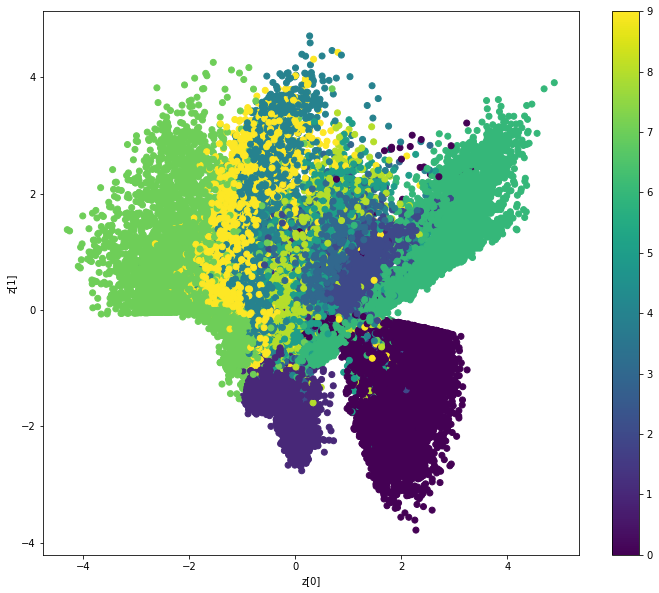

In [16]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)